In [93]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt

In [190]:
# Initial conditions
n = 100 # number of trash
m = 5 # size of grid
k = 6 # number of agents (must be an even number)
mu = [3, 2] # center of trash pile
sig = [[0.1, 0], [0, 0.1]] # spread of pile
var = 0.1 # error in measurements

field = np.zeros((m,m))# array of trash pieces dispersed on field
visits = np.zeros((k,m,m))# array to track number of visits to each gridpoint
reward = np.zeros((k,m,m))# array of sum of rewards from each gridpoint
expected_mean = np.zeros((k,m,m)) # array of expected mean of each gridpoint

T = n # number of time steps
delta = 1 # amount reward decreases per visit
xi = 2 # constant xi > 1
gamma = 3 # max message length

messageSent = {}# dict {agent: list of messages to send - tuple [agent, time, arm, reward]}
messageRec = {}# dict {agent: list of messages received - tuple [agent, time, arm, reward]}

regret = []

In [191]:
for i in range(k):
    messageSent[i] = []
    messageRec[i] = []
    regret.append([0])

In [192]:
# Initialize communication network
# If graph[i][j] = 1 then there is an edge between agents i and j
# Array must be symmetric

# graph = np.ones((k,k))
# Initialize communication network
degree = 4

graph = np.identity(k)
if degree % 2 == 0:
    count = int(degree/2)
    for j in range(count):
        # make vertex for every (i +1) steps away
        for i in range(k):
            neighbor = int(i + j + 1)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
else:
    count = int((degree-1)/2 + 1)
    for j in range(count):
        # make vertex for every n/2 - i steps away
        for i in range(k):
            neighbor = int(i + k/2 - j)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
print(graph)


[[1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]]


In [193]:
# Initialize field
trash = np.random.multivariate_normal(mu, sig, n)
for i in range(n):
    x = int(trash[i][0])
    y = int(trash[i][1])
    field[x][y] += 1
    
print(field)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 24. 26.  0.  0.]
 [ 0. 23. 27.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [194]:
# Initialize agents
t = 0
for i in range(k):
    for x in range(m):
        for y in range(m):
            measure = round(np.random.normal(field[x][y], var),1)
            reward[i][x][y] += measure
            visits[i][x][y] += 1
    
    # Calculate expected mean
    expected_mean[i] = np.divide(reward[i], visits[i])
    

In [195]:
t += 1
while np.max(field) > 0:
    print("t: {}".format(t))
    index = []
    for i in range(k):        
        # Select arm with highest expected Q value
        Q = expected_mean[i] + var*np.divide(math.sqrt(2*(xi + 1)*math.log(t)),np.sqrt(visits[i]))
        ind = np.unravel_index(np.argmax(Q), Q.shape)
        measure = np.round(np.random.normal(field[ind], var),1)
        index.append(ind)
            
        print(ind)
        print(Q)
        print(measure)
        
        # Calculate regret
        optimal_ind = np.unravel_index(np.argmax(field), field.shape)
        max_reward = field[optimal_ind]
        actual_reward = field[ind]
        regret[i].append(max_reward - actual_reward)
            
        # Make message to send to neighboring agents
        message = (t, i, ind, measure)
        send = messageSent[i]
        if len(send) == gamma:
            send.pop(0)
        send.append(message)
        messageSent[i] = send
        
    # Pick up trash from selected grid points
    for i in range(len(index)):
        ind = index[i]
        if field[ind] > 0:
            field[ind] -= 1
                
    
    # receive messages from neighbors and adjust expected mean
    for i in range(k):
        print(i)
        new_visits= np.zeros((m,m))
        # compare new messages with history of messages and skip any repeats
        for j in range(k):
            if graph[i][j] == 1:
                received = messageRec[i]
                sent = messageSent[j]
                for l in range(len(sent)):
                    msg = sent[l]
                    if received.count(msg) == 0:
                        received.append(msg)
                        ind = msg[2]
                        visits[i][ind] += 1
                        new_visits[ind] += 1
                        reward[i][ind] += msg[3]
                messageRec[i] = received
        
        # calculate expected mean
        reward[i] -= np.multiply(new_visits, visits[i])
        # expected_mean[i] = (expected_mean[i] -1) + np.divide(new_reward[i], visits[i])
        expected_mean[i] = np.divide(reward[i], visits[i])
        print(reward[i])
        print(visits[i])
        print(expected_mean[i])
    
    print(field)
    t += 1 



    

t: 1
(3, 2)
[[ 0.  -0.1 -0.3  0.1  0. ]
 [ 0.   0.   0.1 -0.1 -0.2]
 [ 0.  24.  26.1 -0.1  0. ]
 [ 0.2 23.  27.  -0.1  0. ]
 [-0.1  0.   0.2 -0.1  0. ]]
27.2
(3, 2)
[[ 0.2  0.   0.  -0.1  0. ]
 [ 0.  -0.2  0.1  0.  -0.2]
 [-0.1 24.  26.1  0.   0. ]
 [ 0.  22.9 27.1  0.1  0. ]
 [ 0.   0.  -0.1 -0.1  0.1]]
26.9
(3, 2)
[[ 0.   0.  -0.1 -0.1  0.1]
 [ 0.1 -0.2  0.  -0.1  0.1]
 [ 0.1 24.2 26.  -0.2  0.1]
 [ 0.  23.  27.1 -0.1  0.1]
 [ 0.   0.  -0.1 -0.1  0.1]]
26.9
(3, 2)
[[ 0.2 -0.1 -0.1  0.1  0. ]
 [-0.1 -0.1  0.  -0.1  0. ]
 [-0.1 24.  26.2  0.  -0.1]
 [ 0.  23.  26.8 -0.1  0.1]
 [-0.1  0.1  0.1 -0.1  0. ]]
27.0
(3, 2)
[[ 0.1 -0.1 -0.1  0.1  0. ]
 [ 0.   0.  -0.1 -0.1  0. ]
 [ 0.1 23.8 25.9  0.1  0. ]
 [ 0.1 23.  27.   0.   0. ]
 [-0.3  0.1 -0.1  0.1 -0.2]]
27.1
(3, 2)
[[ 0.   0.1  0.   0.   0. ]
 [ 0.  -0.1  0.1 -0.1  0.1]
 [ 0.  23.9 26.  -0.2  0. ]
 [-0.1 23.  27.1 -0.1  0.1]
 [-0.1  0.  -0.2  0.1  0.1]]
27.0
0
[[ 0.000e+00 -1.000e-01 -3.000e-01  1.000e-01  0.000e+00]
 [ 0.000e+00  0.0

 [ 0.25322301  0.45322301  0.45322301  0.25322301  0.35322301]]
17.1
(3, 1)
[[ 0.45322301  0.25322301  0.25322301  0.45322301  0.35322301]
 [ 0.35322301  0.35322301  0.25322301  0.25322301  0.35322301]
 [ 0.45322301 13.64286438 15.68831893  0.45322301  0.35322301]
 [ 0.45322301 18.21086936 16.62468256  0.35322301  0.35322301]
 [ 0.05322301  0.45322301  0.25322301  0.45322301  0.15322301]]
17.1
(3, 1)
[[ 0.35322301  0.45322301  0.35322301  0.35322301  0.35322301]
 [ 0.35322301  0.25322301  0.45322301  0.25322301  0.45322301]
 [ 0.35322301 13.67013711 15.67013711  0.15322301  0.35322301]
 [ 0.25322301 18.21086936 16.62468256  0.25322301  0.45322301]
 [ 0.25322301  0.35322301  0.15322301  0.45322301  0.45322301]]
17.0
0
[[ 0.000e+00 -1.000e-01 -3.000e-01  1.000e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e-01 -1.000e-01 -2.000e-01]
 [ 0.000e+00  1.494e+02  1.715e+02 -1.000e-01  0.000e+00]
 [ 2.000e-01  1.383e+02  1.816e+02 -1.000e-01  0.000e+00]
 [-1.000e-01  0.000e+00  2.000e-01 -1.000

5.1
(3, 1)
[[0.6078668  0.4078668  0.4078668  0.3078668  0.4078668 ]
 [0.4078668  0.2078668  0.5078668  0.4078668  0.2078668 ]
 [0.3078668  2.6556705  4.67471812 0.4078668  0.4078668 ]
 [0.4078668  7.1582167  5.6604324  0.5078668  0.4078668 ]
 [0.4078668  0.4078668  0.3078668  0.3078668  0.5078668 ]]
5.1
(3, 1)
[[0.4078668  0.4078668  0.3078668  0.3078668  0.5078668 ]
 [0.5078668  0.2078668  0.4078668  0.3078668  0.5078668 ]
 [0.5078668  2.6604324  4.66519431 0.2078668  0.5078668 ]
 [0.4078668  7.1957167  5.65090859 0.3078668  0.5078668 ]
 [0.4078668  0.4078668  0.3078668  0.3078668  0.5078668 ]]
5.1
(3, 1)
[[0.6078668  0.3078668  0.3078668  0.5078668  0.4078668 ]
 [0.3078668  0.3078668  0.4078668  0.3078668  0.4078668 ]
 [0.3078668  2.63662288 4.67948002 0.4078668  0.3078668 ]
 [0.4078668  7.2019667  5.61281336 0.3078668  0.5078668 ]
 [0.3078668  0.5078668  0.5078668  0.3078668  0.4078668 ]]
5.1
(3, 1)
[[0.5078668  0.3078668  0.3078668  0.5078668  0.4078668 ]
 [0.4078668  0.4078668  0

In [196]:
print(field)
print(t)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
19


[[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


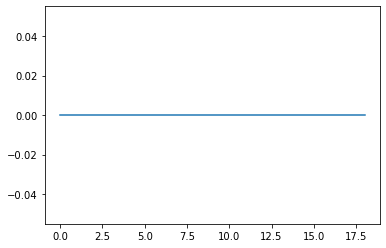

In [197]:
print(regret)
cum_regret = np.cumsum(np.array(regret), axis = 1)
print(cum_regret)
plt.plot(np.arange(t), cum_regret[0])